In [58]:
!pip install segmentation_models_pytorch

  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16446 sha256=26e994becd705ad1bbf347282202fdc653a48625b24756ddd92e286415465376
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60967 sha256=b85453152eca25ba2261bf12822c953af37e4126ea950c4c4c13cab5f0d01ba9
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f534c60142835bfc889f9a482e4a67e0b817032d9c6883b64
Successfully built efficientnet-pytorch pretrainedmodels


In [59]:
from fastai.vision.all import *
import segmentation_models_pytorch as smp


In [2]:
dataroot_dir = Path('dataset/labeled_data')

In [3]:
dataroot_dir.ls()

(#3) [Path('dataset/labeled_data/images'),Path('dataset/labeled_data/.ipynb_checkpoints'),Path('dataset/labeled_data/labels')]

In [6]:
images = get_image_files(dataroot_dir/'images')
images

(#50) [Path('dataset/labeled_data/images/0031.png'),Path('dataset/labeled_data/images/0019.png'),Path('dataset/labeled_data/images/0042.png'),Path('dataset/labeled_data/images/0025.png'),Path('dataset/labeled_data/images/0030.png'),Path('dataset/labeled_data/images/0014.png'),Path('dataset/labeled_data/images/0006.png'),Path('dataset/labeled_data/images/0050.png'),Path('dataset/labeled_data/images/0001.png'),Path('dataset/labeled_data/images/0003.png'),Path('dataset/labeled_data/images/0008.png'),Path('dataset/labeled_data/images/0022.png'),Path('dataset/labeled_data/images/0012.png'),Path('dataset/labeled_data/images/0033.png'),Path('dataset/labeled_data/images/0046.png'),Path('dataset/labeled_data/images/0041.png'),Path('dataset/labeled_data/images/0005.png'),Path('dataset/labeled_data/images/0020.png'),Path('dataset/labeled_data/images/0047.png'),Path('dataset/labeled_data/images/0015.png')...]

In [8]:
im = images[0]; im

Path('dataset/labeled_data/images/0031.png')

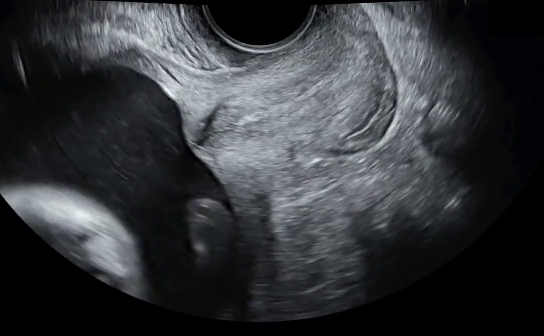

In [9]:
PILImage.create(im)

In [11]:
im.size

AttributeError: 'PosixPath' object has no attribute 'size'

In [12]:
labels = get_image_files(dataroot_dir/'labels')
labels

(#50) [Path('dataset/labeled_data/labels/0031.png'),Path('dataset/labeled_data/labels/0019.png'),Path('dataset/labeled_data/labels/0042.png'),Path('dataset/labeled_data/labels/0025.png'),Path('dataset/labeled_data/labels/0030.png'),Path('dataset/labeled_data/labels/0014.png'),Path('dataset/labeled_data/labels/0006.png'),Path('dataset/labeled_data/labels/0050.png'),Path('dataset/labeled_data/labels/0001.png'),Path('dataset/labeled_data/labels/0003.png'),Path('dataset/labeled_data/labels/0008.png'),Path('dataset/labeled_data/labels/0022.png'),Path('dataset/labeled_data/labels/0012.png'),Path('dataset/labeled_data/labels/0033.png'),Path('dataset/labeled_data/labels/0046.png'),Path('dataset/labeled_data/labels/0041.png'),Path('dataset/labeled_data/labels/0005.png'),Path('dataset/labeled_data/labels/0020.png'),Path('dataset/labeled_data/labels/0047.png'),Path('dataset/labeled_data/labels/0015.png')...]

In [13]:
lbl = labels[0]; lbl

Path('dataset/labeled_data/labels/0031.png')

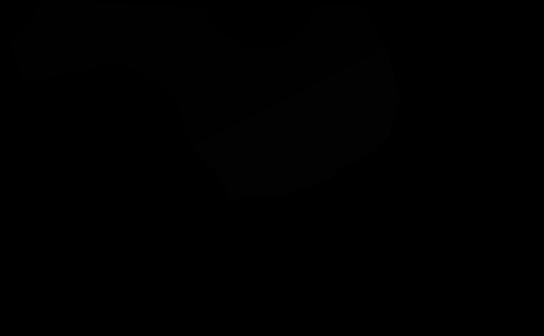

In [18]:
msk = PILMask.create(lbl);msk

- DataLoaders -> DataLoader(TrainingSet), DataLoader(ValidationSet) - Dataset - x, y - Datablock

In [19]:
np.unique(msk)

array([0, 1, 2], dtype=uint8)

In [16]:
cervcal_codes=['Background','AnteriorLip', 'PosteriorLip']

In [27]:
cervcal_datablocks = (ImageBlock, MaskBlock(codes=cervcal_codes))


In [28]:
def get_y(x): return Path(str(x).replace('images','labels'))

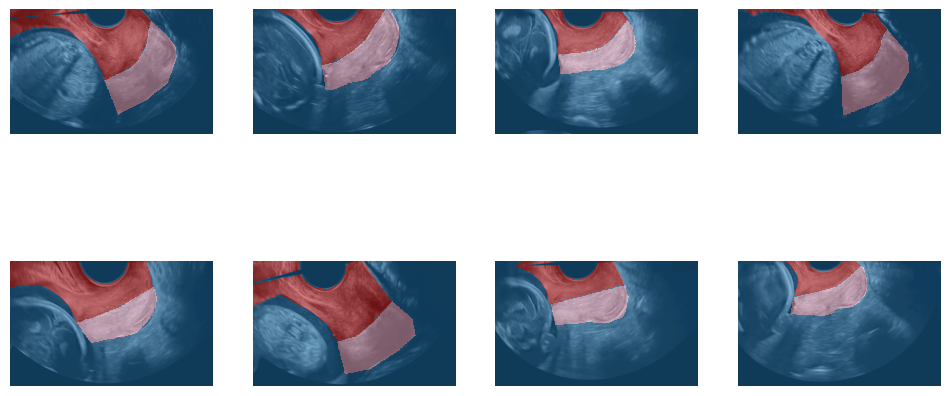

In [71]:
datablock = DataBlock(
    blocks = cervcal_datablocks,
    get_items = get_image_files,
    get_y = get_y,
    splitter=RandomSplitter(),
    batch_tfms=[*aug_transforms(), Normalize.from_stats(*imagenet_stats)])

dls = datablock.dataloaders(dataroot_dir/'images', bs=8)

dls.show_batch()

In [72]:
xb, yb = dls.one_batch()

In [73]:
xb.shape, yb.shape

(torch.Size([8, 3, 336, 544]), torch.Size([8, 336, 544]))

In [74]:
xb.unique()

TensorImage([-2.1179, -2.1179, -2.1179,  ...,  2.6226,  2.6359,  2.6395],
            device='cuda:0')

In [75]:
yb.unique()

TensorMask([0, 1, 2], device='cuda:0')

In [76]:
len(dls.train_ds)

40

In [77]:
len(dls.valid_ds)

10

In [78]:
num_classes=3

model = smp.DeepLabV3Plus(
    encoder_name='efficientnet-b5',
    encoder_weights='imagenet',
    in_channels=3,
    classes=num_classes,
    activation=None
)


In [61]:
# Define TverskyLoss
TverskyLoss = smp.losses.TverskyLoss(mode='multilabel', log_loss=False)

def tversky_loss(y_pred, y_true):
    y_true = F.one_hot(y_true, num_classes=num_classes).permute(0, 3, 1, 2).float()
    return TverskyLoss(y_pred, y_true)

def criterion(y_pred, y_true):
    fl = FocalLossFlat(axis=1)(y_pred, y_true)
    tl = tversky_loss(y_pred, y_true)
    
    return 0.5*fl + 0.5*tl

In [83]:
learn = Learner(dls, model, loss_func=FocalLossFlat(axis=1), metrics=[foreground_acc, DiceMulti(axis=1)],opt_func=ranger).to_fp16()

In [84]:
learn.fine_tune(10)  # Fine-tune for 10 epochs (adjust as needed)

epoch,train_loss,valid_loss,foreground_acc,dice_multi,time
0,0.387750,0.429155,0.018724,0.307986,00:02


epoch,train_loss,valid_loss,foreground_acc,dice_multi,time
0,0.379968,0.416142,0.023857,0.312014,00:03
1,0.366369,0.393134,0.217876,0.433226,00:03
2,0.333487,0.347570,0.453918,0.503143,00:03
3,0.294388,0.290035,0.575104,0.658094,00:03
4,0.256403,0.240001,0.668211,0.723991,00:03
5,0.223821,0.185286,0.740258,0.782108,00:03
6,0.198699,0.169334,0.843712,0.801587,00:03
7,0.177763,0.132036,0.812232,0.818867,00:03
8,0.161070,0.113871,0.786940,0.824721,00:03
9,0.147732,0.104907,0.771086,0.826703,00:03


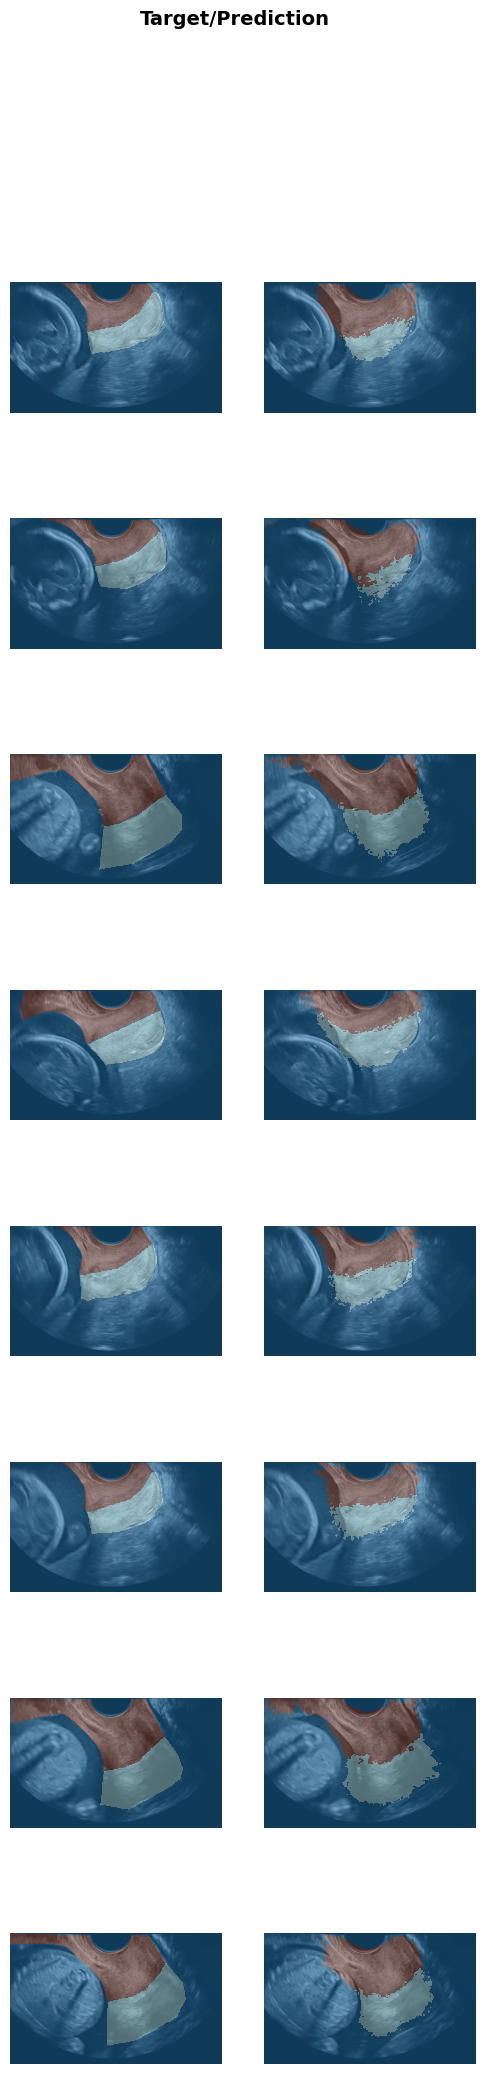

In [85]:
learn.show_results(vmin=0, vmax=2, cmap='tab20')

In [87]:
learn.export('cervical_baseline_model_v1.pkl')  # Save the trained model